# Tooth Caries Segmentation

## Tooth Caries Segmentation using SAM

### Install needed packages

In [12]:
import os
HOME = os.getcwd()
print("HOME:", HOME)
%cd {HOME}
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q supervision
!mkdir {HOME}/weights
%cd {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

#Roboflow packages

!pip install roboflow

HOME: /kaggle/working/weights
/kaggle/working/weights
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-xlj5us04
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-xlj5us04
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
/kaggle/working/weights/weights
  Obtaining dependency information for roboflow from https://files.pythonhosted.org/packages/f7/69/530445f36a3435638a7d137a3e60590f2fc68c46260623ca57c108110b4f/roboflow-1.1.14-py3-none-any.whl.metadata
  Obtaining dependency information for certifi==2023.7.22 from https://files.pythonhosted.org/packages/4c/dd/2234eab22353ffc7d94e8d13177aaa050113286e93e7b40eae01fbf7c3d9/certifi-2023.7.22-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

### Import needed packages

In [3]:
import os
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import supervision as sv

from roboflow import Roboflow
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### check on the weights

In [4]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/kaggle/working/weights/sam_vit_h_4b8939.pth ; exist: True


### Set the device

In [5]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Initialize the model

In [8]:
MODEL_TYPE = "vit_h"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

### Get the images paths

In [9]:
#IMAGE_PATH = "/kaggle/input/dental-caries/Caries1.png"
IMAGE_PATHS = ["/kaggle/input/dental-caries/Caries1.png", "/kaggle/input/dental-caries/caries2.png",
               "/kaggle/input/dental-caries/caries3.png"]


### Segment the images and show them

In [29]:
def show_images_side_by_side(img1,img2):
    sv.plot_images_grid(
        images=[img1,img2],
        grid_size=(1, 2),
        titles=['source image', 'segmented image']
    )

In [30]:
def segment_and_show(IMAGE_PATH):
    image_bgr = cv2.imread(IMAGE_PATH)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    sam_result = mask_generator.generate(image_rgb)
    mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
    detections = sv.Detections.from_sam(sam_result=sam_result)

    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    
    show_images_side_by_side(image_bgr, annotated_image)

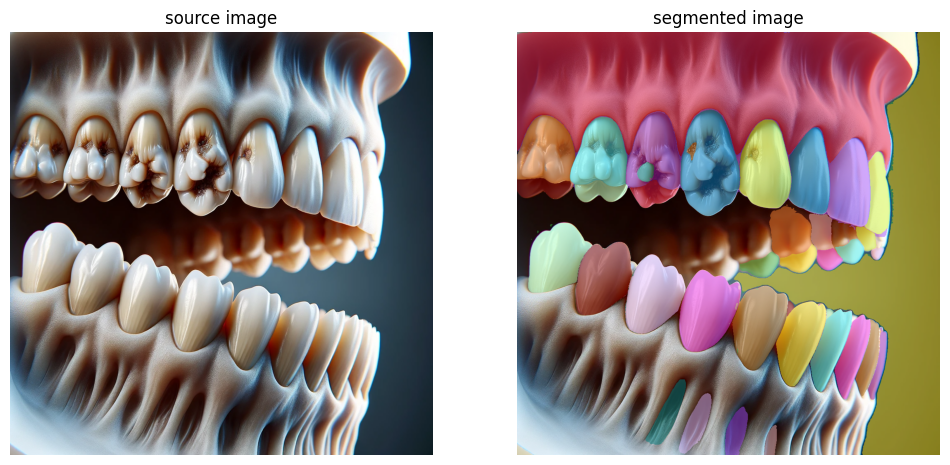

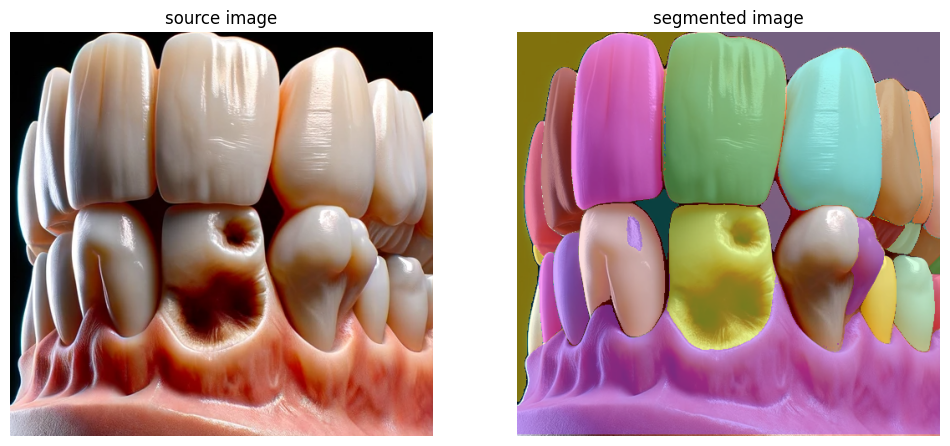

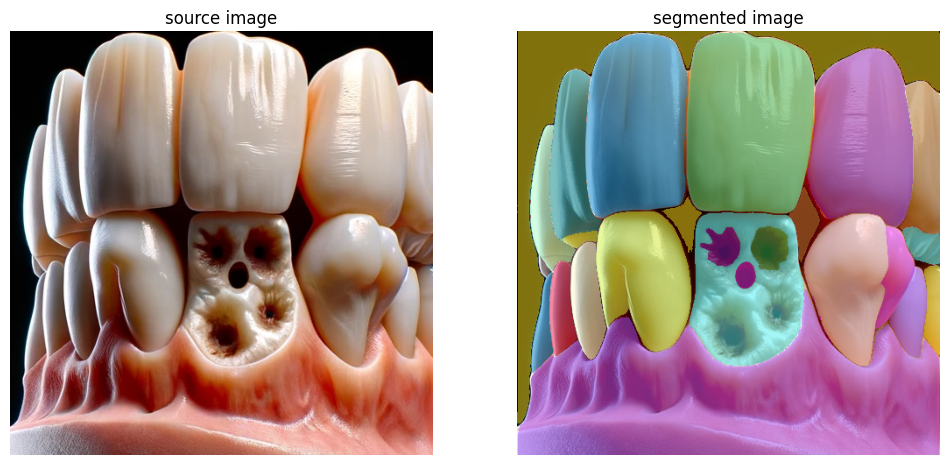

In [31]:
for IMAGE_PATH in IMAGE_PATHS:
    segment_and_show(IMAGE_PATH)

## Tooth Caries Segmentation using Caries detection from Roboflow

Roboflow has a varity of pre-trained models that was trained on different tasks, you can try those models online on their website or by using Roboflow API, those models are very handy 

In [21]:
%cd
%cd {HOME}
%cd ..

/root
/kaggle/working/weights
/kaggle/working


### Load the model from Roboflow

In [22]:
rf = Roboflow(api_key="Wp522Q7EXoboZNoq11wB")
project = rf.workspace().project("caries-detection-euzne")
model = project.version(1).model

loading Roboflow workspace...
loading Roboflow project...


### Turn .png images to JPG

In [32]:
def png_to_jpg(img_path1,img_path2):
    im1 = Image.open(img_path1).convert("RGB")
    im1.save(img_path2)

In [38]:
JPG_IMAGES_PATH = "/kaggle/working/"
JPG_IMAGES_PATHS = []
i=0
for IMAGE_PATH in IMAGE_PATHS:
    JPG_PATH = JPG_IMAGES_PATH+str(i)+".jpg"
    JPG_IMAGES_PATHS.append(JPG_PATH)
    png_to_jpg(IMAGE_PATH,JPG_PATH)
    i+=1
print(JPG_IMAGES_PATHS)

['/kaggle/working/0.jpg', '/kaggle/working/1.jpg', '/kaggle/working/2.jpg']


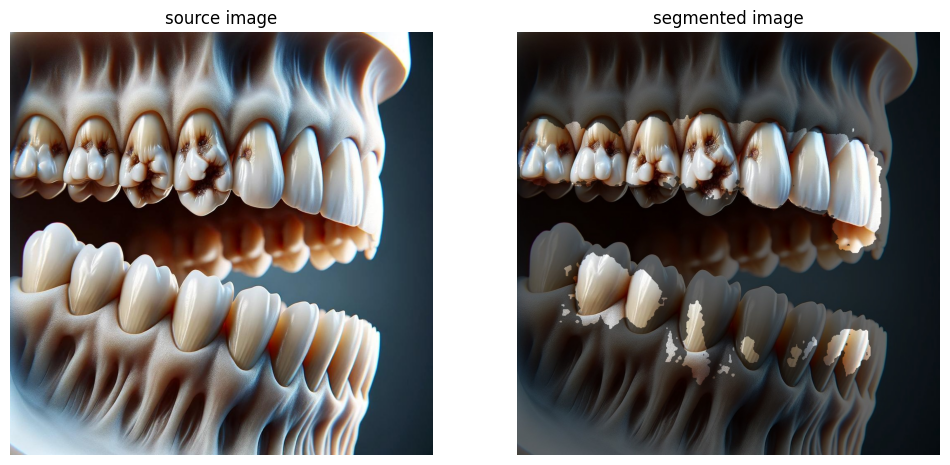

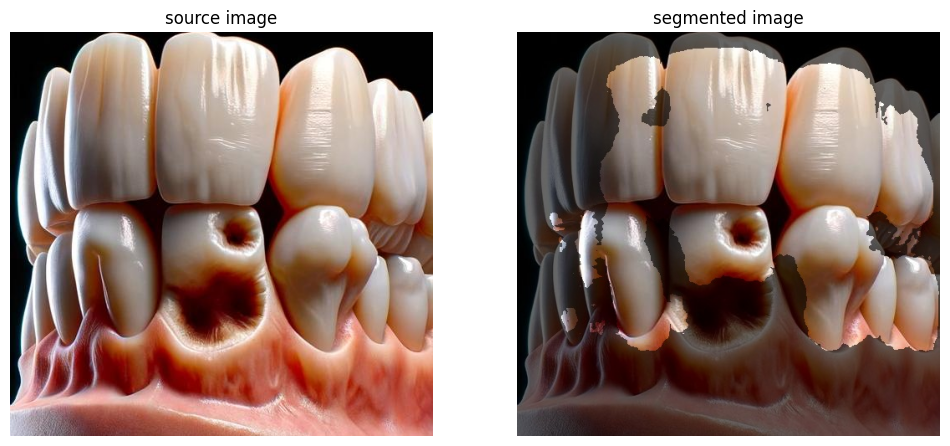

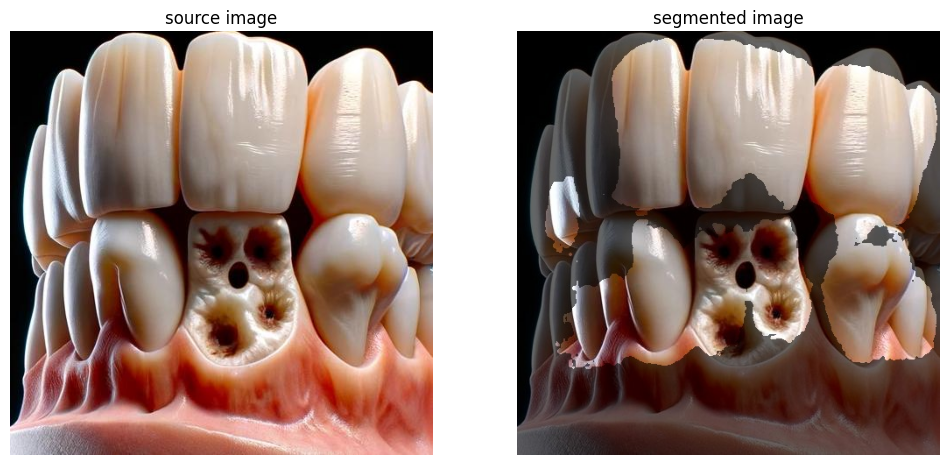

In [42]:
i=0
for JPG_IMAGE_PATH in JPG_IMAGES_PATHS:
    model.predict(JPG_IMAGE_PATH).save("prediction"+str(i)+".jpg")
    org_image = cv2.imread(JPG_IMAGE_PATH)
    seg_image = cv2.imread("prediction"+str(i)+".jpg")
    show_images_side_by_side(org_image,seg_image)
    i+=1
